# 0. Keras code block for reproducible results during development

In [1]:
import numpy as np
import tensorflow as tf
import random as rn

# The below is necessary in Python 3.2.3 onwards to
# have reproducible behavior for certain hash-based operations.
# See these references for further details:
# https://docs.python.org/3.4/using/cmdline.html#envvar-PYTHONHASHSEED
# https://github.com/fchollet/keras/issues/2280#issuecomment-306959926

import os
os.environ['PYTHONHASHSEED'] = '0'

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.

np.random.seed(42)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.

rn.seed(12345)

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of
# non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res

session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

from keras import backend as K

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed

tf.set_random_seed(1234)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

# Rest of code follows ...

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# 1. Import essential libraries 

In [2]:
from keras.models import Model
from keras.layers import Activation, Conv2D, Dense, Flatten, Input, MaxPooling2D
from keras.datasets import mnist

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

import matplotlib.pyplot as plt
%matplotlib inline
import cv2

import pickle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import itertools

In [3]:
#curpath = os.environ['PATH']
#curpath += ':/usr/local/lib/python3.5/dist-packages/graphviz'
#os.environ['PATH'] = curpath

# 2. Create the model

In [4]:
model_name = 'mnist_cnn'

img_channels = 1
img_rows = 32
img_cols = 32
num_conv_filters = 32
conv_filter_width = 5
conv_filter_height = 5

if K.image_data_format() == 'channels_first':
    img_shape = (img_channels, img_rows, img_cols)
else:
    img_shape = (img_rows, img_cols, img_channels)

In [5]:
# With functional API
inputs = Input(shape=img_shape)
x = Conv2D(6, (conv_filter_width, conv_filter_height))(inputs)
x = Activation('sigmoid')(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Conv2D(16, (conv_filter_width, conv_filter_height))(x)
x = Activation('sigmoid')(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Conv2D(120, (conv_filter_width, conv_filter_height))(x)
x = Activation('sigmoid')(x)
x = Flatten()(x)
x = Dense(84)(x)
x = Activation('relu')(x)
x = Dense(10)(x)
predictions = Activation('softmax')(x)

model = Model(inputs=inputs, outputs=predictions)

In [6]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 3. Visualize the model

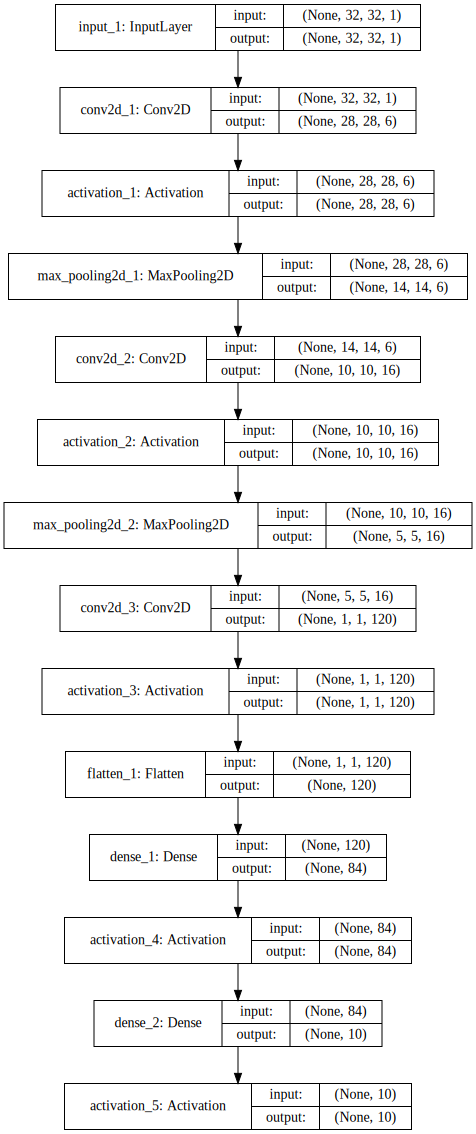

In [7]:
plot_model(model, show_shapes=True, to_file=model_name+'_viz.png')
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 6)         156       
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 6)         0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
activation_2 (Activation)    (None, 10, 10, 16)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 16)          0         
__________

# 4. Load dataset 

In [9]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 2s 0us/step


In [10]:
print('{0} training samples and {1} test samples'. format(x_train.shape[0], x_test.shape[0]))

60000 training samples and 10000 test samples


In [11]:
# we need to pad the images to match their shape to 32x32 pixels
x_train = np.lib.pad(x_train, ((0,0), (2,2), (2,2)), 'constant')
x_test = np.lib.pad(x_test, ((0,0), (2,2), (2,2)), 'constant')

In [12]:
# reshape data to appropriate size
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], img_channels, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], img_channels, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, img_channels)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, img_channels)

In [13]:
x_train.shape

(60000, 32, 32, 1)

In [14]:
x_test.shape

(10000, 32, 32, 1)

In [15]:
# normalize the data
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# 5. Train the model

In [16]:
batch_size = 128
num_epochs = 3

train_history = model.fit(x_train, y_train, batch_size=batch_size, epochs=num_epochs, \
                          validation_data=(x_test, y_test), shuffle=True)
#train_history = model.fit(x_train, y_train, batch_size=batch_size, epochs=num_epochs, \
#                          validation_split=0.2, shuffle=True)

Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 17s 290us/step - loss: 1.2524 - acc: 0.5722 - val_loss: 0.3066 - val_acc: 0.9090
Epoch 2/3
60000/60000 [==============================] - 5s 80us/step - loss: 0.2262 - acc: 0.9307 - val_loss: 0.1557 - val_acc: 0.9481
Epoch 3/3
60000/60000 [==============================] - 5s 79us/step - loss: 0.1401 - acc: 0.9557 - val_loss: 0.1149 - val_acc: 0.9647


# 6. Save the model and training history

In [17]:
model.save(model_name+'_weights.h5')
with open(model_name+'_hist', 'wb') as hist_file:
    pickle.dump(train_history.history, hist_file)

# 7. Visualize training history

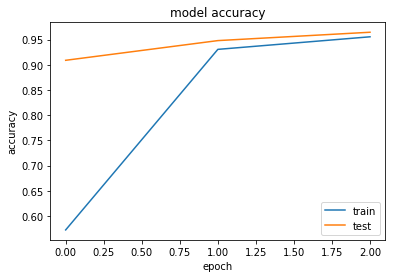

In [18]:
# summarize history for accuracy
plt.plot(train_history.history['acc'])
plt.plot(train_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

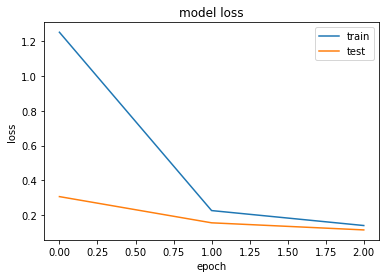

In [19]:
# summarize history for loss
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# 8. Load saved model

In [20]:
from keras.models import load_model

model = load_model(model_name+'_weights.h5')

# 9. Predictions on test data

In [21]:
model.evaluate(x_test, y_test)

10000/10000 [==============================] - 1s 79us/step


[0.11489494682773947, 0.9647]

In [22]:
y_prob = model.predict(x_test, verbose=1)

10000/10000 [==============================] - 1s 52us/step


In [23]:
y_pred = y_prob.argmax(axis=-1)

# 10. Evaluate predictions performance

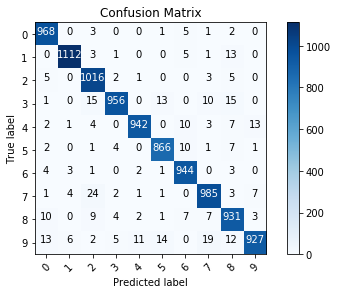

In [24]:
cm = confusion_matrix(y_test, y_pred)

classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

plt.figure()

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')


plt.show()

In [25]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.96      0.99      0.97       980
          1       0.99      0.98      0.98      1135
          2       0.94      0.98      0.96      1032
          3       0.98      0.95      0.96      1010
          4       0.98      0.96      0.97       982
          5       0.97      0.97      0.97       892
          6       0.96      0.99      0.97       958
          7       0.96      0.96      0.96      1028
          8       0.93      0.96      0.94       974
          9       0.97      0.92      0.95      1009

avg / total       0.97      0.96      0.96     10000



# 11. Error analysis 

In [26]:
incorrects = np.nonzero(y_pred != y_test)

In [27]:
incorrects

(array([  18,   33,   65,   73,  104,  241,  247,  259,  320,  340,  394,
         435,  445,  448,  449,  479,  495,  497,  511,  553,  565,  578,
         582,  591,  619,  684,  707,  717,  720,  740,  760,  810,  829,
         844,  882,  894,  896,  938,  947,  950,  959,  965,  982, 1003,
        1014, 1032, 1039, 1044, 1062, 1093, 1107, 1112, 1114, 1119, 1156,
        1159, 1178, 1181, 1206, 1226, 1232, 1247, 1256, 1283, 1290, 1299,
        1319, 1326, 1355, 1364, 1378, 1393, 1429, 1500, 1522, 1527, 1530,
        1549, 1553, 1570, 1571, 1581, 1621, 1634, 1681, 1695, 1709, 1717,
        1721, 1737, 1754, 1828, 1850, 1878, 1901, 1938, 1952, 1955, 2016,
        2018, 2043, 2070, 2098, 2107, 2109, 2129, 2130, 2135, 2168, 2174,
        2182, 2185, 2189, 2229, 2237, 2266, 2272, 2280, 2293, 2325, 2358,
        2380, 2387, 2395, 2406, 2422, 2447, 2534, 2560, 2573, 2582, 2598,
        2607, 2648, 2654, 2780, 2896, 2927, 2945, 2952, 2953, 3005, 3030,
        3060, 3073, 3117, 3129, 3130, 

In [28]:
idx = incorrects[0][0]

In [29]:
idx

18

# Visualize the filters

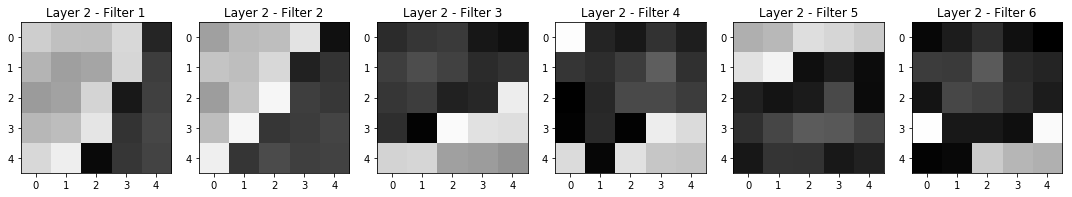

In [30]:
layer = 1
plt.figure(1, figsize=(15,15))
#W = np.squeeze(model.layers[layer].get_weights()[0])
#W = np.reshape(W, (32,3,3,1))
for row in range(1):
    for col in range(6):
        imgnum = row*6+col
        if imgnum > 31:
            break
        filter = model.layers[layer].get_weights()[0][:,:,:,imgnum]
        #filter = W[imgnum,:,:]
        filter /= 2
        filter += 1
        img = cv2.cvtColor(filter, cv2.COLOR_GRAY2RGB)
        plt.subplot(6,6,imgnum+1)
        plt.title('Layer {0} - Filter {1}'.format(layer+1, imgnum+1))
        plt.imshow(img)
        

plt.tight_layout()
plt.show()

### 1. View the input image 

In [31]:
idx = 2
img = x_train[idx]
img.shape

(32, 32, 1)

In [32]:
disp_img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
disp_img.shape

(32, 32, 3)

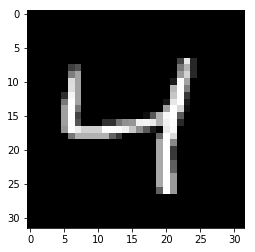

In [33]:
plt.imshow(disp_img)
plt.show()

In [34]:
y_train[idx]

4

# 2. View the output of first convolution layer

In [35]:
layer = 2
get_layer_output = K.function([model.layers[0].input], [model.layers[1].output])

In [36]:
r_img = np.reshape(img, (1, 32, 32, 1))
layer_output = get_layer_output([r_img])

In [37]:
layer_output[0].shape

(1, 28, 28, 6)

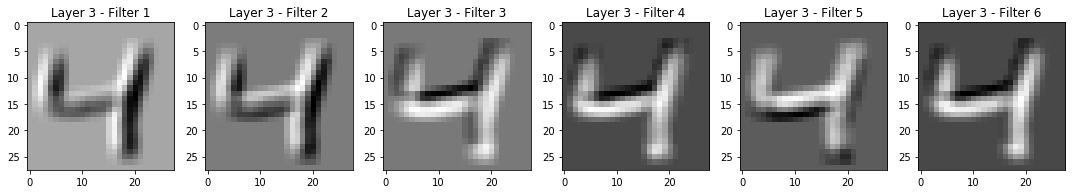

In [38]:
plt.figure(1, figsize=(15,15))

activs = layer_output[0]
activs = np.squeeze(layer_output[0])

for row in range(1):
    for col in range(6):
        imgnum = row*6+col
        if imgnum > 31:
            break
        filter = activs[:,:,imgnum]
        activ_img = cv2.cvtColor(filter, cv2.COLOR_GRAY2RGB)
        plt.subplot(6,6,imgnum+1)
        plt.title('Layer {0} - Filter {1}'.format(layer+1, imgnum+1))
        #plt.imshow(activ_img)
        plt.imshow(filter, cmap='gray')
        

plt.tight_layout()
plt.show()

# 2. View the output of first max pooling layer

In [39]:
layer = 3
get_layer_output = K.function([model.layers[0].input], [model.layers[layer].output])

In [40]:
r_img = np.reshape(img, (1, 32, 32, 1))
layer_output = get_layer_output([r_img])

In [41]:
layer_output[0].shape

(1, 14, 14, 6)

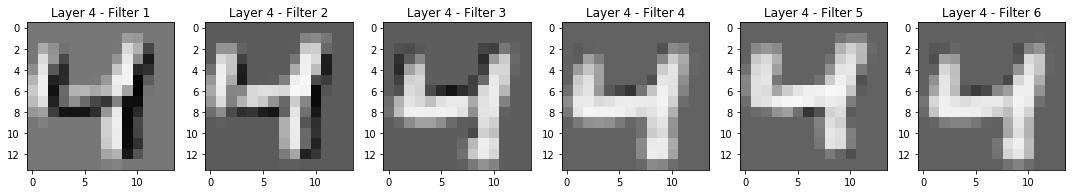

In [42]:
plt.figure(1, figsize=(15,15))

activs = layer_output[0]
activs = np.squeeze(layer_output[0])

for row in range(1):
    for col in range(6):
        imgnum = row*6+col
        if imgnum > 5:
            break
        filter = activs[:,:,imgnum]
        activ_img = cv2.cvtColor(filter, cv2.COLOR_GRAY2RGB)
        plt.subplot(6,6,imgnum+1)
        plt.title('Layer {0} - Filter {1}'.format(layer+1, imgnum+1))
        plt.imshow(activ_img)
        

plt.tight_layout()
plt.show()
        

# 3. View the output of second convolution layer

In [43]:
layer = 4
get_layer_output = K.function([model.layers[0].input], [model.layers[layer].output])

In [44]:
r_img = np.reshape(img, (1, 32, 32, 1))
layer_output = get_layer_output([r_img])

In [45]:
layer_output[0].shape

(1, 10, 10, 16)

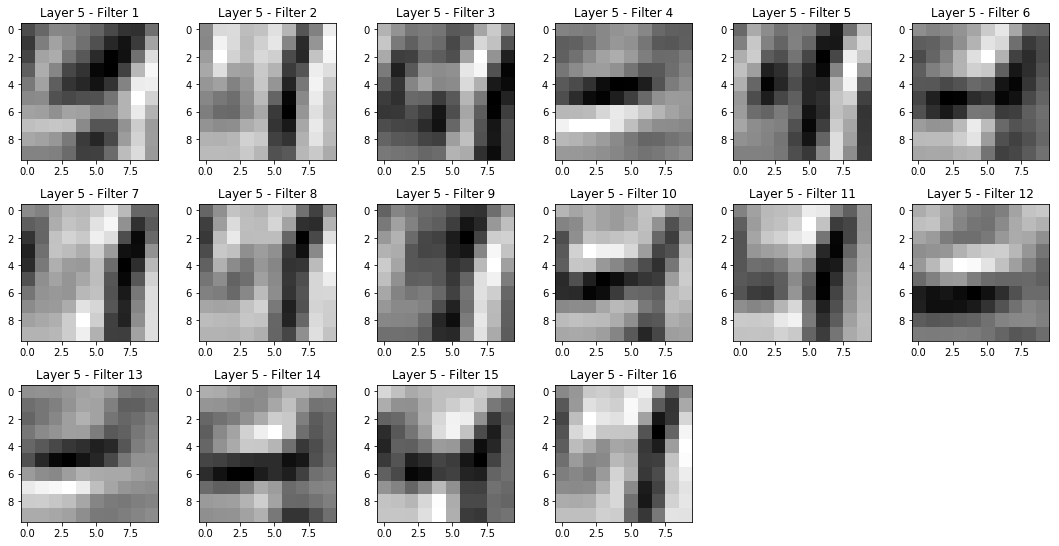

In [46]:
plt.figure(1, figsize=(15,15))

activs = layer_output[0]
activs = np.squeeze(layer_output[0])

for row in range(3):
    for col in range(6):
        imgnum = row*6+col
        if imgnum > 15:
            break
        filter = activs[:,:,imgnum]
        activ_img = cv2.cvtColor(filter, cv2.COLOR_GRAY2RGB)
        plt.subplot(6,6,imgnum+1)
        plt.title('Layer {0} - Filter {1}'.format(layer+1, imgnum+1))
        #plt.imshow(activ_img)
        plt.imshow(filter, cmap='gray')
        

plt.tight_layout()
plt.show()
        

# 4. View the output of second max pooling layer

In [47]:
layer = 5
get_layer_output = K.function([model.layers[0].input], [model.layers[layer].output])

In [48]:
r_img = np.reshape(img, (1, 32, 32, 1))
layer_output = get_layer_output([r_img])

In [49]:
layer_output[0].shape

(1, 10, 10, 16)

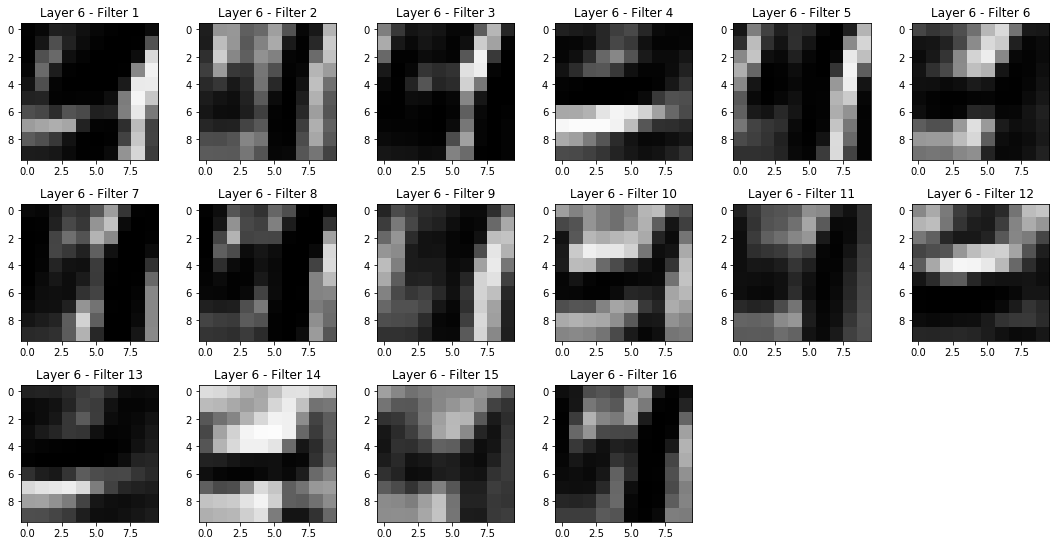

In [50]:
plt.figure(1, figsize=(15,15))

activs = layer_output[0]
activs = np.squeeze(layer_output[0])

for row in range(3):
    for col in range(6):
        imgnum = row*6+col
        if imgnum > 15:
            break
        filter = activs[:,:,imgnum]
        activ_img = cv2.cvtColor(filter, cv2.COLOR_GRAY2RGB)
        plt.subplot(6,6,imgnum+1)
        plt.title('Layer {0} - Filter {1}'.format(layer+1, imgnum+1))
        plt.imshow(activ_img)
        

plt.tight_layout()
plt.show()